In [13]:
# Load packages
import numpy as np
import pandas as pd
import catboost as cat
#import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn_pandas import DataFrameMapper
from sklearn_pandas import CategoricalImputer
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline
from pandas import read_hdf
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
%%time
df = read_hdf("data.h5")
df.shape

CPU times: user 1.52 s, sys: 550 ms, total: 2.07 s
Wall time: 2.09 s


## 1. Data preprocessing
1. Remove duplicate columns.

In [3]:
col  = list(df.columns.values)
for k in list(df.columns.values):
  if "_txt" in k:
    col.remove(k)
df = df[col]
df.shape

(181691, 107)

2. Remove text features first, later use NLP to explore.

In [4]:
col_text = ["resolution","summary","approxdate","eventid","motive","weapdetail","propcomment","addnotes","scite1","scite2","scite3","related"]
col_fin = [x for x in col if x not in col_text]
df = df[col_fin]
df.shape

(181691, 95)

3. Remove 'Unkown' data points since it is irrelevant, maybe add in for more robust model

In [5]:
df  = df[df['gname'] != 'Unknown']
df.shape

(98909, 95)

4. Determine the size of the set of gangs we want to predict, start with a filter equal to 100 data points.

In [6]:
major_gang = df.groupby("gname").size()[df.groupby('gname').size() > 1].index.values
bool_isin = [(k["gname"] in major_gang) for _,k in df.iterrows()]
df_model = df.loc[bool_isin]
df_model.shape

(97198, 95)

5. Choose category features

In [7]:
cat_feat  =list(df_model.dtypes[df_model.dtypes == object].index)
cat_feat.remove("provstate")
cat_feat.remove("city")
cat_feat.remove("dbsource")
cat_feat.remove("gname")
model_feat = [k for k  in df_model.columns if k not in cat_feat]
df_model = df_model[model_feat]

## 2. Train model

In [8]:
X= df_model.drop(['gname'], axis=1)
y = df_model.iloc[:,32] 

# fill NANs 
X = X.fillna(-999)

# Label encoder
for c in X.columns[X.dtypes == 'object']:
    X[c] = X[c].factorize()[0]

Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test= train_test_split(X, y,test_size=0.2, random_state=123,stratify=y)


rf = RandomForestClassifier(n_estimators=50, n_jobs= 100)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=100,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# 3. Evaluate Result

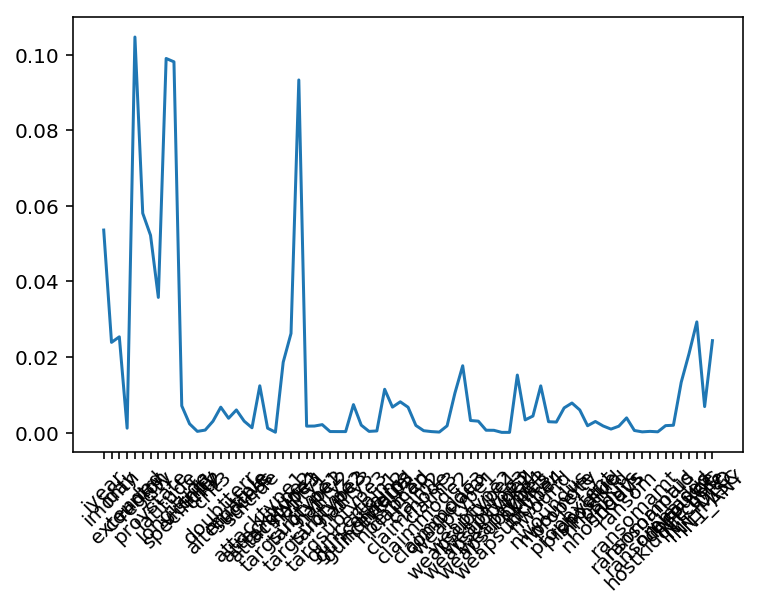

In [24]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.plot(rf.feature_importances_)
plt.xticks(np.arange(X.shape[1]), X.columns.tolist(), rotation=45)
plt.show()

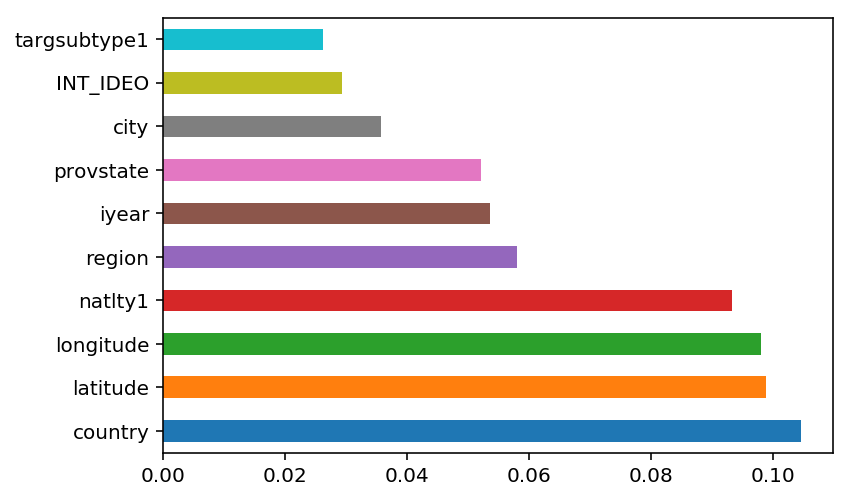

In [25]:
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')

In [26]:
from sklearn.metrics import accuracy_score
train_predictions = rf.predict(X_test)
acc = accuracy_score(y_test, train_predictions)
print("Accuracy: {:.4%}".format(acc))

Accuracy: 85.8076%
